## Import des packages

In [53]:
from scipy.stats import binom
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns 
from scipy import stats
import statsmodels.graphics.tsaplots as tsa

### Question 1

In [54]:
data_open = pd.read_csv('OpenhealthS-Grippal.csv', delimiter=';')

In [55]:
data_open.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,"1,7","2,2","2,3"
1,2009-07-02,"3,4","2,1","2,3"
2,2009-07-03,"2,1","2,1","2,3"
3,2009-07-04,"1,3",2,"2,3"
4,2009-07-05,"14,2",2,"2,3"


In [56]:
data_open.dtypes

PERIODE                  object
IAS_brut                 object
IAS_lisse                object
Incidence_Sentinelles    object
dtype: object

In [57]:
data_open.shape

(1752, 4)

In [58]:
data_open['IAS_brut'] = data_open['IAS_brut'].str.replace(',', '.')

In [59]:
data_open['IAS_brut'] = pd.to_numeric(data_open['IAS_brut'])
data_open['PERIODE'] = pd.to_datetime(data_open['PERIODE'])

In [60]:
data_open.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,"2,2","2,3"
1,2009-07-02,3.4,"2,1","2,3"
2,2009-07-03,2.1,"2,1","2,3"
3,2009-07-04,1.3,2,"2,3"
4,2009-07-05,14.2,2,"2,3"


In [61]:
date_max = data_open['PERIODE'].max()
date_min = data_open['PERIODE'].min()

#### Valeurs nulles

In [62]:
valeurs_null = data_open.loc[data_open['IAS_brut'] == 0].index

In [63]:
valeurs_null

Int64Index([340, 378, 627, 732, 858, 1062, 1075, 1502], dtype='int64')

In [64]:
data_open.loc[341]

PERIODE                  2010-06-07 00:00:00
IAS_brut                                   1
IAS_lisse                                0,9
Incidence_Sentinelles                    0,9
Name: 341, dtype: object

In [65]:
for i in valeurs_null:
    data_open.loc[i,'IAS_brut' ] = (data_open.loc[i+1,'IAS_brut'] + data_open.loc[i-1,'IAS_brut']) / 2

### Question 2

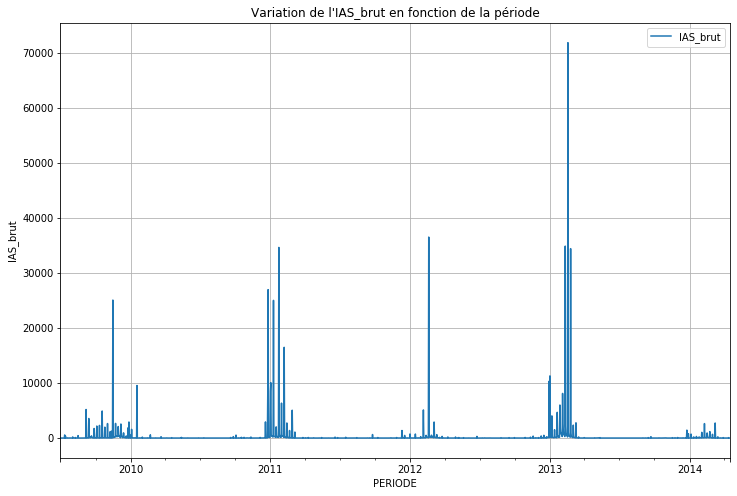

In [66]:
data_open.plot(x='PERIODE', y='IAS_brut', figsize=(12,8))
plt.ylabel('IAS_brut')
plt.title("Variation de l'IAS_brut en fonction de la période")
plt.grid()

On observe en général les pics d'IAS_brut en hiver entre Novembre et avril avec le pic le plus important survenu en Février 2013.

### Question 3

Text(0.5, 1.0, 'Histogramme de la loi marginale')

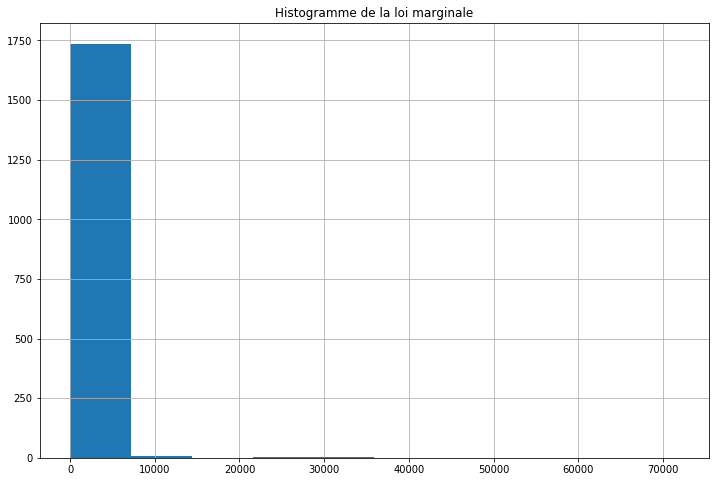

In [67]:
data_open['IAS_brut'].hist(figsize=(12,8))
plt.title('Histogramme de la loi marginale')

### Question 4

A partir de cette question, travailler uniquement avec les données logarithmiques

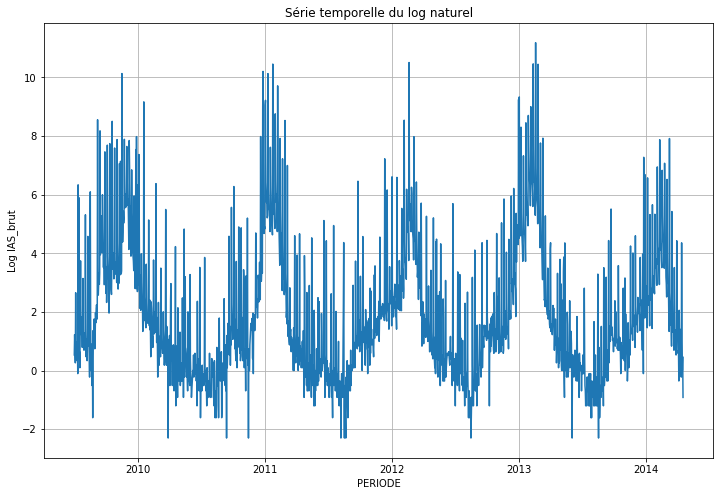

In [68]:
plt.figure(figsize = (12,8))
x = data_open['PERIODE']
y = np.log(data_open['IAS_brut'])
plt.plot(x, y)
plt.grid()
plt.title('Série temporelle du log naturel')
plt.xlabel('PERIODE')
plt.ylabel('Log IAS_brut')
plt.show()

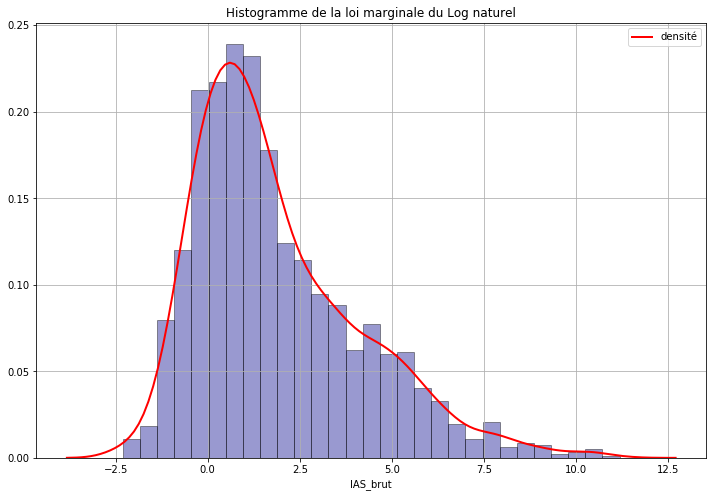

In [69]:
plt.figure(figsize = (12,8))
sns.distplot(y, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},
                 kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.title('Histogramme de la loi marginale du Log naturel')
plt.grid()

Le log naturel permet de réduire l'asymétrie des données donc de mieux visualiser la variation de l'IAS_brut entre, les mois d'une même année et d'une année à l'autre.

### Question 5

In [70]:
IAS = data_open.set_index('PERIODE')['IAS_brut']

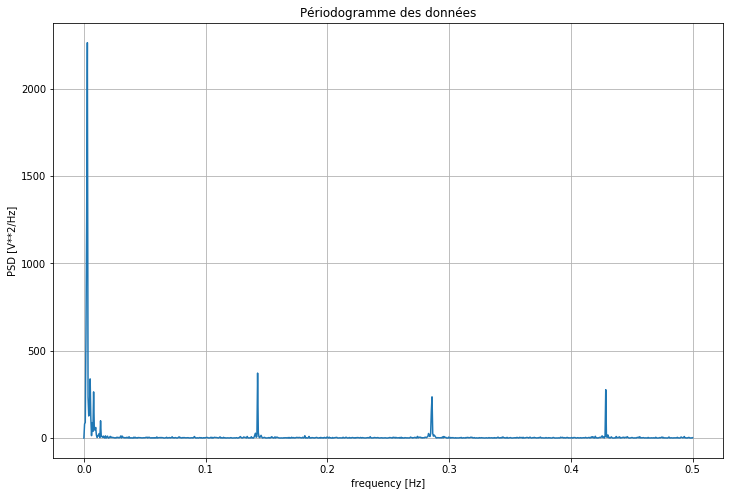

In [71]:
f, Pxx_den = signal.periodogram(np.log(data_open['IAS_brut']))
plt.figure(figsize = (12,8))
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Périodogramme des données')
plt.grid()
plt.show()

Le périodogramme est une estimation simple de la densité spectrale.
Les pics les plus significatifs correspondent aux valeurs sur plusieurs. Le pic observé pour la fréquence **0.15** correspond aux observations sur 7 jours.

### Question 6

In [72]:
data_open_log = pd.DataFrame(data_open, columns=['PERIODE', 'IAS_brut'])

In [73]:
data_open_log.head()

,PERIODE,IAS_brut
0,2009-07-01,1.7
1,2009-07-02,3.4
2,2009-07-03,2.1
3,2009-07-04,1.3
4,2009-07-05,14.2


In [74]:
data_open_log['IAS_brut'] = np.log(data_open_log['IAS_brut'])

In [75]:
data_open_log = data_open_log.set_index('PERIODE')

In [76]:
data_open_log.head()

,IAS_brut
PERIODE,
2009-07-01,0.530628
2009-07-02,1.223775
2009-07-03,0.741937
2009-07-04,0.262364
2009-07-05,2.653242


In [77]:
shift = data_open_log.shift(365)

In [78]:
data_open_shift = data_open_log - shift

In [79]:
data_open_shift.head()

,IAS_brut
PERIODE,
2009-07-01,NaN
2009-07-02,NaN
2009-07-03,NaN
2009-07-04,NaN
2009-07-05,NaN


In [80]:
data_open_shift = data_open_shift[data_open_shift['IAS_brut'].isna() == False]

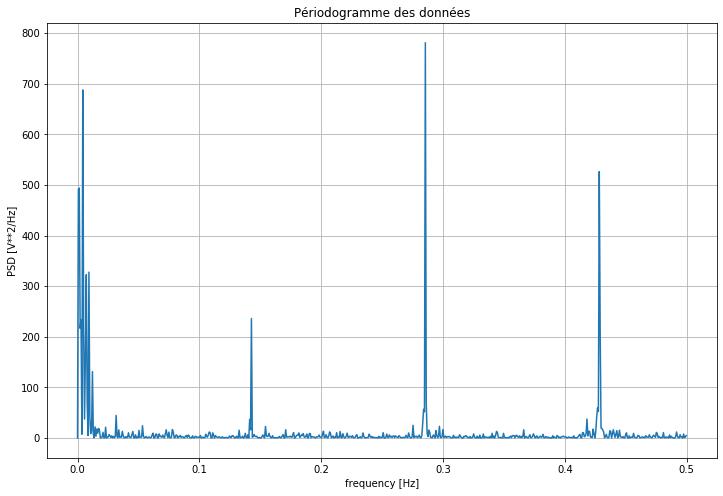

In [81]:
f, Pxx_den = signal.periodogram(data_open_shift['IAS_brut'])
plt.figure(figsize = (12,8))
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Périodogramme des données')
plt.grid()
plt.show()

Cette fonction a fait disparaître le pic de puissance en 0 qui représentait le bruit.

### Question 7

In [82]:
data_tot = data_open_log.reset_index()

In [83]:
data_tot.head()

,PERIODE,IAS_brut
0,2009-07-01,0.530628
1,2009-07-02,1.223775
2,2009-07-03,0.741937
3,2009-07-04,0.262364
4,2009-07-05,2.653242


In [84]:
for i in range(len(data_tot)):
    data_tot.loc[i, 't'] = i

In [85]:
data_tot = data_tot.set_index('PERIODE')

In [86]:
n_harmo = 6
T = 365
for k in range(1, n_harmo):
        data_tot['cos'+str(k)] = np.cos(data_tot['t']*k*2*math.pi/T)
        data_tot['sin'+str(k)] = np.sin(data_tot['t']*k*2*math.pi/T)

In [87]:
data_tot = data_tot.drop(columns=['t'])
data_tot.head()

,IAS_brut,cos1,sin1,cos2,sin2,cos3,sin3,cos4,sin4,cos5,sin5
PERIODE,,,,,,,,,,,
2009-07-01,0.530628,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2009-07-02,1.223775,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802,0.996298,0.085965
2009-07-03,0.741937,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279,0.985220,0.171293
2009-07-04,0.262364,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104,0.966848,0.255353
2009-07-05,2.653242,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958,0.941317,0.337523


In [88]:
data_test = data_tot.loc['2013-04-01':'2014-04-17']
data_train = data_tot.loc['2009-07-01':'2013-03-31']

In [89]:
train_cols =['cos1','sin1','cos2','sin2','cos3','sin3','cos4','sin4','cos5','sin5']
data_train_x = data_train[train_cols]
data_train_y = data_train['IAS_brut']

data_test_x = data_test[train_cols]
data_test_y = data_test['IAS_brut']

In [90]:
model_linear = linear_model.LinearRegression(fit_intercept=True)
model_linear.fit(data_train_x, data_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
data_test_y_predict = model_linear.predict(data_test_x)
risque_quad = mean_squared_error(data_test_y, data_test_y_predict)
print('La valeur du risque quadratique est : '+str(round(risque_quad,3)))

La valeur du risque quadratique est : 1.88


In [92]:
data_tot['IAS_brut_pred'] = model_linear.predict(data_tot[train_cols])

In [93]:
data_tot.head()

,IAS_brut,cos1,sin1,cos2,sin2,cos3,sin3,cos4,sin4,cos5,sin5,IAS_brut_pred
PERIODE,,,,,,,,,,,,
2009-07-01,0.530628,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.488336
2009-07-02,1.223775,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802,0.996298,0.085965,0.498346
2009-07-03,0.741937,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279,0.985220,0.171293,0.507135
2009-07-04,0.262364,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104,0.966848,0.255353,0.514574
2009-07-05,2.653242,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958,0.941317,0.337523,0.520541


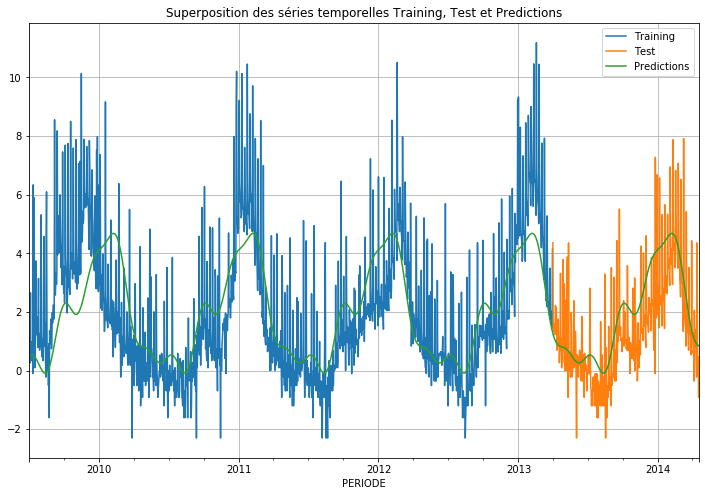

In [95]:
plt.figure(figsize = (12,8))
data_tot['IAS_brut']['2009-07-01':'2013-03-31'].plot(label="Training")
data_tot['IAS_brut']['2013-04-01':'2014-04-17'].plot(label="Test")
data_tot['IAS_brut_pred'].plot(label="Predictions")
plt.legend()
plt.title("Superposition des séries temporelles Training, Test et Predictions")
plt.grid()
plt.show()

### Courbe des résidus

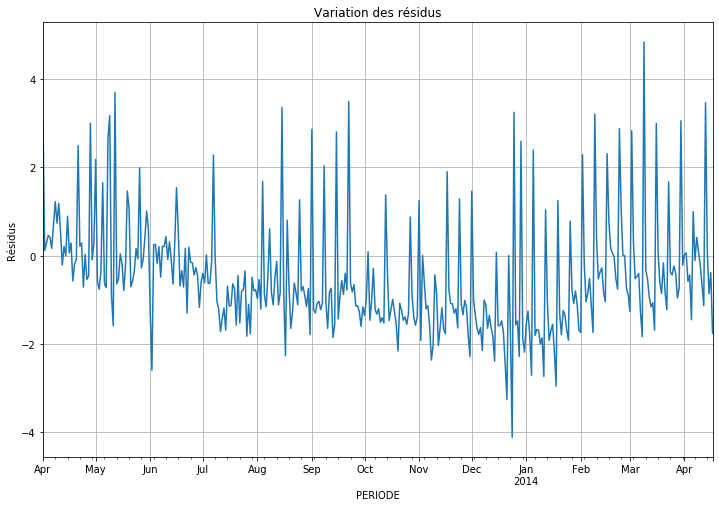

In [96]:
plt.figure(figsize = (12,8))
(data_test_y - data_test_y_predict).plot()
plt.ylabel("Résidus")
plt.title("Variation des résidus")
plt.grid()
plt.show()

In [97]:
n_harmo = 6
cols = data_tot.columns[1:]
cols_cos = []
cols_sin = []
mean_square_arr = []
for k in range(1, n_harmo):
    cols_cos.append('cos'+str(k))
    cols_sin.append('sin'+str(k))
    
    cols_reg = cols_cos + cols_sin
    data_train_x_h = data_train[cols_reg]
    data_train_y_h = data_train['IAS_brut']

    data_test_x_h = data_test[cols_reg]
    data_test_y_h = data_test['IAS_brut']
    
    model_linear_h = linear_model.LinearRegression(fit_intercept=True)
    model_linear_h.fit(data_train_x_h, data_train_y_h)
    
    data_test_y_predict_h = model_linear_h.predict(data_test_x_h)
    risque_quad_h = mean_squared_error(data_test_y_h, data_test_y_predict_h)
    mean_square_arr.append(risque_quad_h)

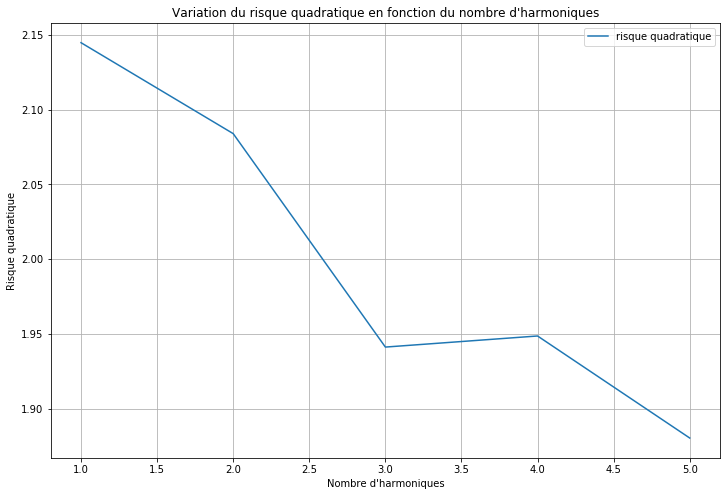

In [98]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,6), mean_square_arr, label='risque quadratique')
plt.xlabel("Nombre d'harmoniques")
plt.ylabel("Risque quadratique")
plt.title("Variation du risque quadratique en fonction du nombre d'harmoniques")
plt.grid()
plt.legend()
plt.show()

## Données “Trafic internet” 

### Question 8

In [99]:
col_int = ["time_stamp", "source_host", "destination_host", "source_port", "destination_port", "bytes"]

In [100]:
data_int = pd.read_csv("lbl-tcp-3.tcp", delimiter=" ", names = col_int, header=None)

In [101]:
data_int.head()

,time_stamp,source_host,destination_host,source_port,destination_port,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


In [102]:
data_int['datetime'] = pd.to_datetime(data_int['time_stamp'], unit='s')

In [103]:
data_int['datetime'] = data_int['datetime'].astype('str')

In [104]:
data_int['datetime']= pd.to_datetime(data_int['datetime'].str.split('.').str[0])

In [105]:
data_int.head()

,time_stamp,source_host,destination_host,source_port,destination_port,bytes,datetime
0,7.591038e+08,1,2,23,2436,1,1994-01-20 22:10:00
1,1.044500e-02,2,1,2436,23,2,1970-01-01 00:00:00
2,2.377500e-02,1,2,23,2436,2,1970-01-01 00:00:00
3,2.655800e-02,2,1,2436,23,1,1970-01-01 00:00:00
4,2.900200e-02,3,4,3930,119,42,1970-01-01 00:00:00


In [106]:
data_int_group_ = data_int.loc[1:]

In [107]:
data_int_group_.dtypes

time_stamp                 float64
source_host                  int64
destination_host             int64
source_port                  int64
destination_port             int64
bytes                        int64
datetime            datetime64[ns]
dtype: object

In [108]:
data_int_group_ = data_int_group_.drop(columns=['time_stamp','source_host','destination_host','source_port','destination_port'])

In [109]:
data_int_group_ = data_int_group_.set_index('datetime')

In [110]:
data_int_group = data_int_group_.resample('10S', how={'bytes':'count'})

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


In [111]:
data_int_group.head()

,bytes
datetime,
1970-01-01 00:00:00,1614
1970-01-01 00:00:10,1729
1970-01-01 00:00:20,3220
1970-01-01 00:00:30,1767
1970-01-01 00:00:40,1891


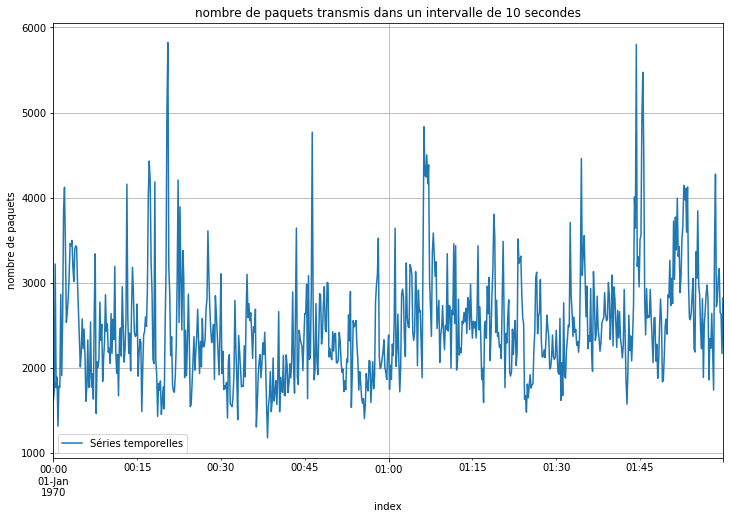

In [112]:
plt.figure(figsize = (12,8))
data_int_group['bytes'].plot(label="Séries temporelles")
plt.title('nombre de paquets transmis dans un intervalle de 10 secondes')
plt.xlabel('index')
plt.ylabel('nombre de paquets')
plt.grid()
plt.legend()
plt.show()

### Question 9

#### Méthode AIC et BIC

In [113]:
data_int_train = data_int_group['1970-01-01 00:00:00':'1970-01-01 01:15:00']['bytes']
data_int_test = data_int_group['1970-01-01 01:15:01':]['bytes']

In [114]:
aic_arr = []
bic_arr = []
for p in range(1,15):
    model_arima = ARIMA(data_int_train, order=(p,0,0))
    model_fit_arima = model_arima.fit(disp=0)
    aic_ = model_fit_arima.aic
    bic_ = model_fit_arima.bic
    aic_arr.append(aic_)
    bic_arr.append(bic_)

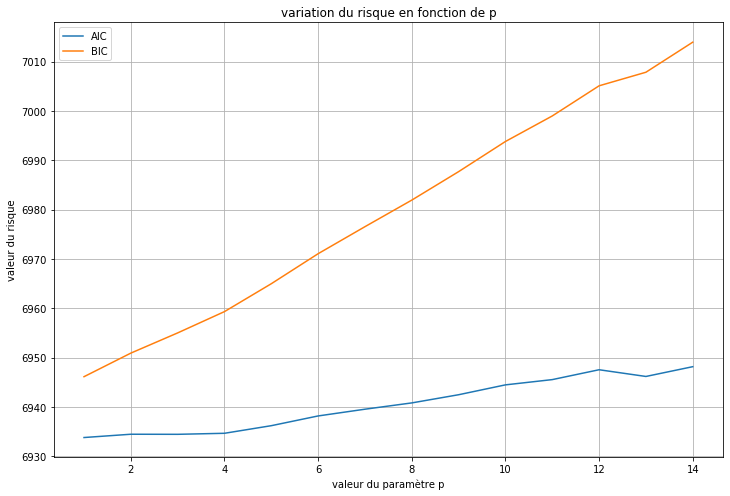

In [115]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,15), aic_arr, label='AIC')
plt.plot(np.arange(1,15), bic_arr, label='BIC')
plt.xlabel('valeur du paramètre p')
plt.ylabel('valeur du risque')
plt.title('variation du risque en fonction de p')
plt.grid()
plt.legend()
plt.show()

#### Cross validation

In [26]:
tscv = TimeSeriesSplit(n_splits=4)
risque_mean = []
aic_mean = []
bic_mean = []
for p in range(1,12):
    risque_int = []
    aic_int = []
    bic_int = []
    for train_index, test_index in tscv.split(data_int_group):
        data_train = data_int_group[min(train_index):]['bytes']
        data_test = data_int_group[min(test_index):]['bytes']
        model_arima = ARIMA(data_train, order=(p,0,0))
        model_fit_arima = model_arima.fit(disp=0)
        aic_int.append(model_fit_arima.aic)
        bic_int.append(model_fit_arima.bic)
        prediction = model_fit_arima.predict(start=min(data_test.index), end=max(data_test.index))
        risque_quad_cv = mean_squared_error(data_test, prediction)
        risque_int.append(risque_quad_cv)
    risque_mean.append(np.mean(risque_int))
    aic_mean.append(np.mean(aic_int))
    bic_mean.append(np.mean(bic_int))

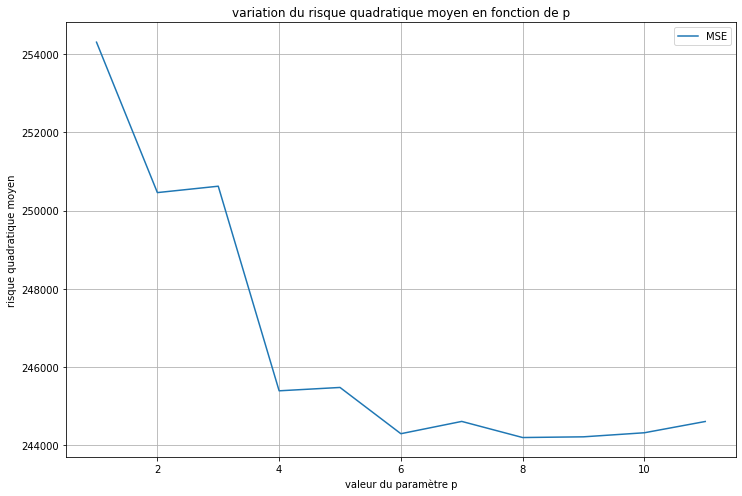

In [30]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,12), risque_mean, label='MSE')
plt.xlabel('valeur du paramètre p')
plt.ylabel('risque quadratique moyen')
plt.title('variation du risque quadratique moyen en fonction de p')
plt.grid()
plt.legend()
plt.show()

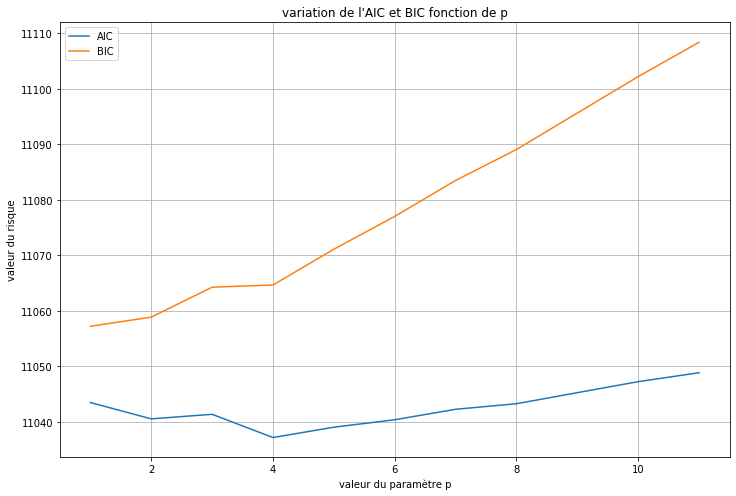

In [29]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,12), aic_mean, label='AIC')
plt.plot(np.arange(1,12), bic_mean, label='BIC')
plt.xlabel('valeur du paramètre p')
plt.ylabel('valeur du risque')
plt.title("variation de l'AIC et BIC fonction de p")
plt.grid()
plt.legend()
plt.show()

En se basant sur le critère AIC, nous allons prendre **p=4.**

### Question 10

In [116]:
# fit model
model_arima = ARIMA(data_int_train, order=(4,0,0))
model_fit_arima = model_arima.fit(disp=0)
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  bytes   No. Observations:                  451
Model:                     ARMA(4, 0)   Log Likelihood               -3461.331
Method:                       css-mle   S.D. of innovations            520.794
Date:                Sun, 26 Jan 2020   AIC                           6934.662
Time:                        20:33:44   BIC                           6959.330
Sample:                    01-01-1970   HQIC                          6944.384
                         - 01-01-1970                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2392.2687     70.515     33.926      0.000    2254.062    2530.475
ar.L1.bytes     0.5428      0.047     11.558      0.000       0.451       0.635
ar.L2.bytes     0.0163      0.054      0.305      0.761      -0.089       0.121
ar.L3.bytes     0.0316      0.054      0.584      0.559      -0.074       0.138
ar.L4.bytes     0.0636      0.047      1.340      0.181      -0.029       0.157
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3121           -0.0000j            1.3121           -0.0000
AR.2            0.3881           -2.1183j            2.1536           -0.2212
AR.3            0.3881           +2.1183j            2.1536            0.2212
AR.4           -2.5857           -0.0000j            2.5857           -0.5000
-----------------------------------------------------------------------------
"""

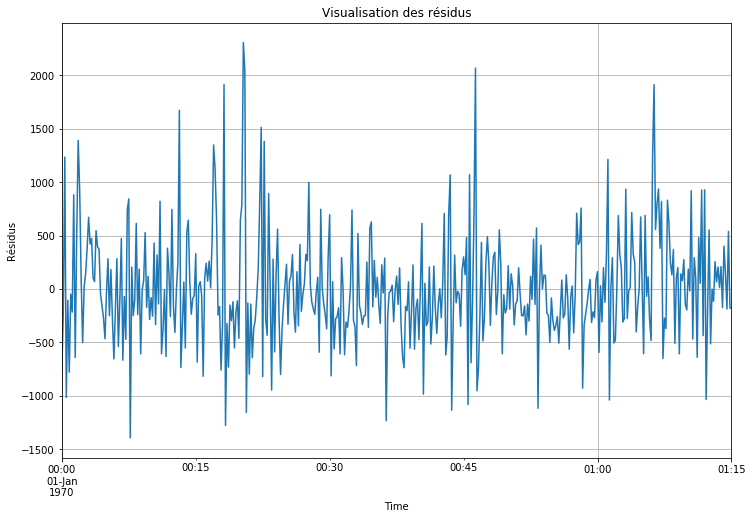

In [117]:
# plot residual errors
plt.figure(figsize = (12,8))
residuals = model_fit_arima.resid
residuals.plot()
plt.title('Visualisation des résidus')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Résidus')
plt.show()

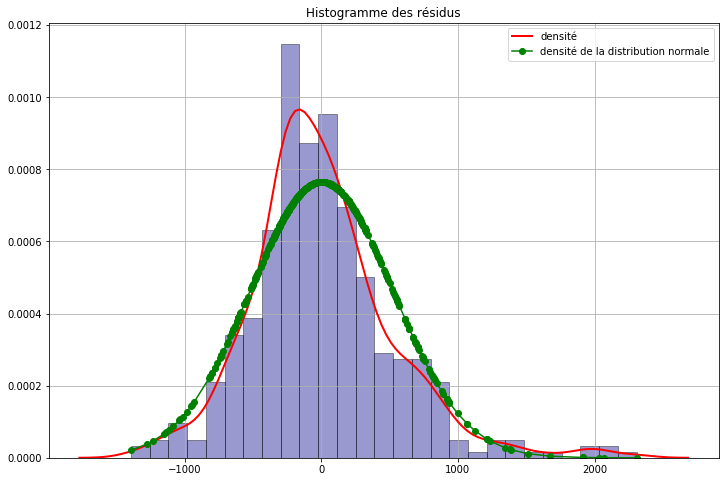

In [118]:
plt.figure(figsize = (12,8))
res = residuals.sort_values(0)
norm_ = stats.norm.pdf(res, np.mean(res), np.std(res))
sns.distplot(residuals, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},
                 kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.plot(res,norm_,'-o', color='green', label='densité de la distribution normale')
plt.title('Histogramme des résidus')
plt.legend()
plt.grid()

On Constate que les résidus sont gaussiens mais ne sont pas distribués suivant une loi normale centrée.

## Données “Southern oscillation index” 

### Question 11

In [119]:
data_soi = pd.read_csv("soi.tsv", delimiter="\t", header=None).T
data_soi.head()

,0
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


In [120]:
data_soi = data_soi.dropna()

### Question 12

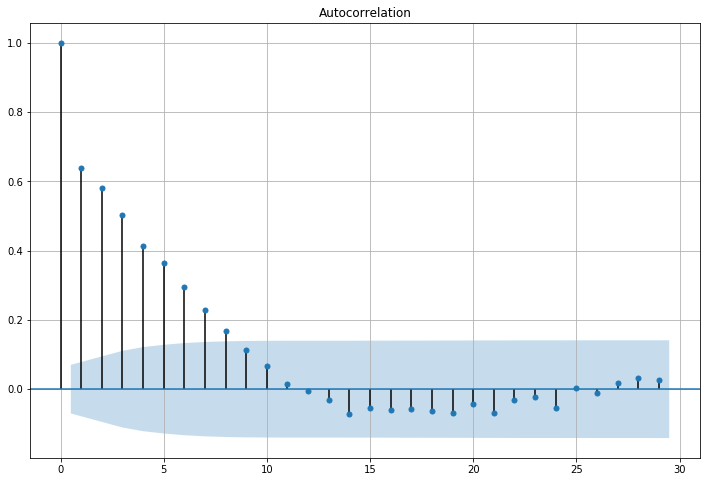

In [121]:
fig, ax = plt.subplots(figsize=(12, 8))
tsa.plot_acf(data_soi, ax=ax)
plt.grid()

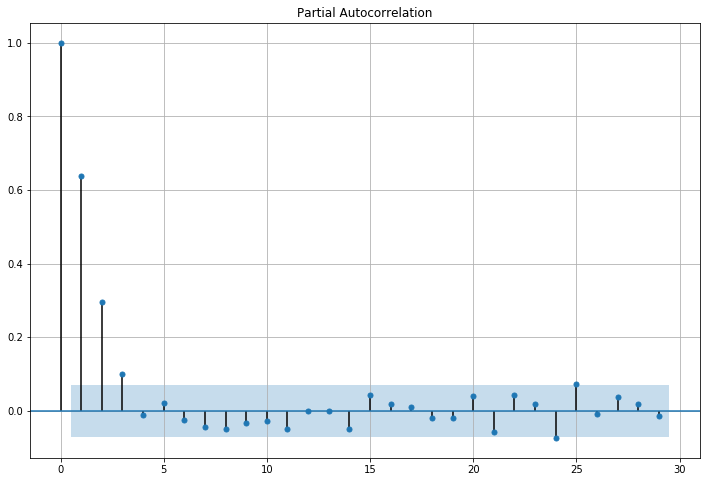

In [122]:
fig, ax = plt.subplots(figsize=(12, 8))
tsa.plot_pacf(data_soi, ax=ax)
plt.grid()

### Question 13

L’ordre du processus auto-régressive AR(p) est **3** car au-delà, l autocorrélation n'est plus significative

In [123]:
model_tsa = ARIMA(data_soi, order=(3,0,0))
model_fit_tsa = model_tsa.fit()

In [124]:
model_fit_tsa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      0   No. Observations:                  780
Model:                     ARMA(3, 0)   Log Likelihood                -821.339
Method:                       css-mle   S.D. of innovations              0.693
Date:                Sun, 26 Jan 2020   AIC                           1652.678
Time:                        20:38:18   BIC                           1675.975
Sample:                             0   HQIC                          1661.638
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1287      0.107      1.199      0.231      -0.082       0.339
ar.L1.0        0.4214      0.036     11.820      0.000       0.352       0.491
ar.L2.0        0.2501      0.038      6.643      0.000       0.176       0.324
ar.L3.0        0.0987      0.036      2.761      0.006       0.029       0.169
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1745           -0.0000j            1.1745           -0.0000
AR.2           -1.8539           -2.2772j            2.9364           -0.3587
AR.3           -1.8539           +2.2772j            2.9364            0.3587
-----------------------------------------------------------------------------
"""

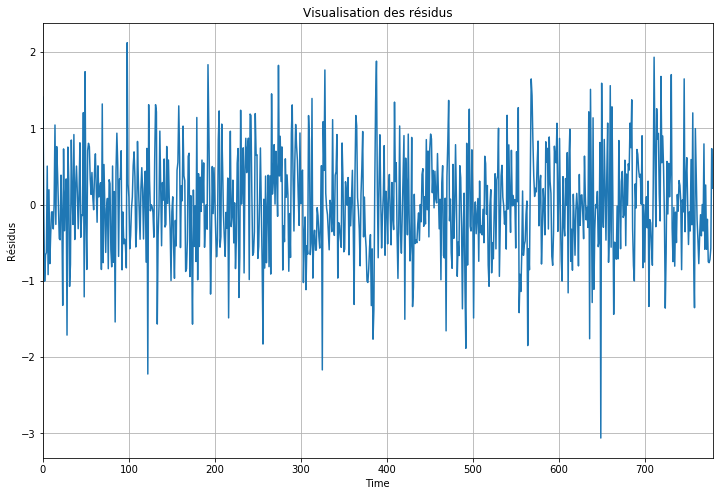

In [125]:
# plot residual errors
plt.figure(figsize = (12,8))
residuals_tsa = model_fit_tsa.resid
residuals_tsa.plot()
plt.grid()
plt.title('Visualisation des résidus')
plt.xlabel('Time')
plt.ylabel('Résidus')
plt.show()

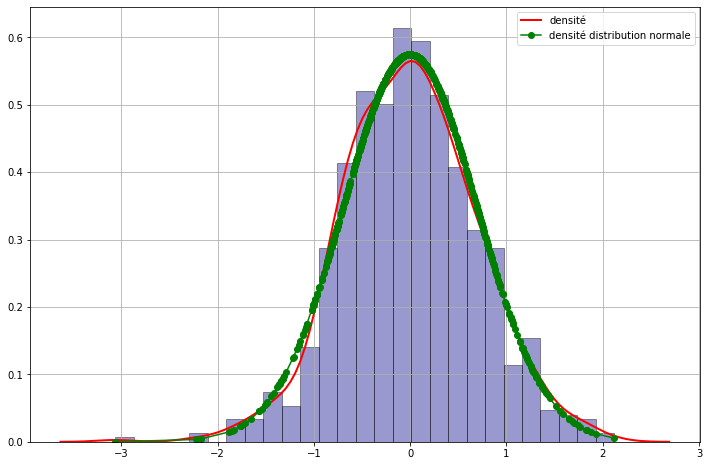

In [126]:
plt.figure(figsize = (12,8))
res_tsa = residuals_tsa.sort_values(0)
norm_tsa = stats.norm.pdf(res_tsa, np.mean(res_tsa), np.std(res_tsa))
sns.distplot(residuals_tsa, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},
                 kde=True, kde_kws = {'color': 'red', 'lw': 2,  'label':'densité'})
plt.plot(res_tsa,norm_tsa,'-o', color='green', label='densité distribution normale')
plt.legend()
plt.grid()

On constate que les résidus suivent la même loi que la densité de distribution normale.

### Question 14

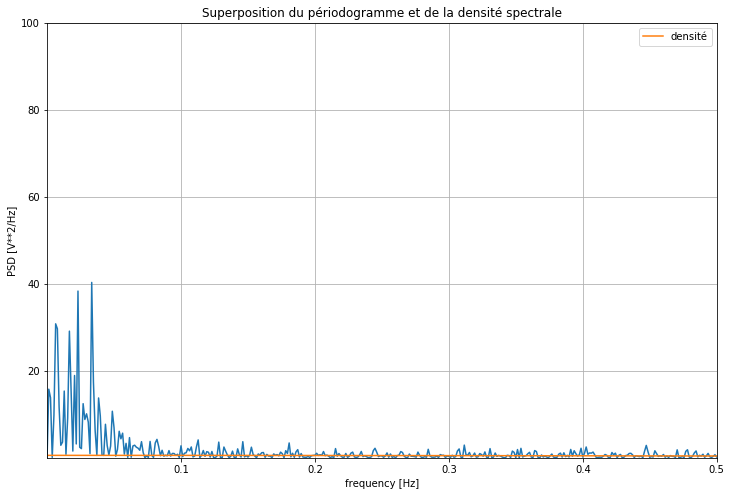

In [128]:
plt.figure(figsize = (12,8))
f, Pxx_den = signal.periodogram(data_soi[0])
plt.plot(f, Pxx_den)
residuals_tsa.plot(kind='kde', label='densité')
plt.title('Superposition du périodogramme et de la densité spectrale')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([1e-10, 0.5])
plt.ylim([1e-3, 1e+2])
plt.legend()
plt.grid()
plt.show()